# DC GAN





## Connect Google Drive

Mount the Google Drive to Google Colab. We will upload all of our dataset to Drive.

In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    print("Google Drive mounted successfully!")
    %tensorflow_version 2.x
except Exception as e:
    print("Error while mounting Google Drive: {}".format(str(e)))

Mounted at /content/drive
Google Drive mounted successfully!


## Import libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import numpy as np
from PIL import Image
from tqdm import tqdm
import os 
import time
import matplotlib.pyplot as plt
from IPython import display


In [ ]:
# Convert seconds to HH:MM:SS.MS format
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

In [ ]:
IMAGE_CHANNELS = 3
GENERATE_RESOLUTION_FACTOR = 3
GENERATE_SQUARE = 32 * GENERATE_RESOLUTION_FACTOR

# Preview image details
PREVIEW_ROWS, PREVIEW_COLS = 4, 7
PREVIEW_MARGIN = 16

# Source vector size to generate images
SEED_SIZE = 100

# Model configuration
DATA_PATH = '/content/drive/My Drive/projects/cartoons/'
FOLDER_NAME = 'cartoonset30k'

EPOCHS = 200
BATCH_SIZE = 64
BUFFER_SIZE = 61000

print(f"Image details: {GENERATE_SQUARE}px")

Image details: 96px


In [ ]:
# Note, that file is large enough to cause problems for sume verisons of Pickle,
# so Numpy binary files are used.
training_binary_path = os.path.join(DATA_PATH,
        f'training_data_{FOLDER_NAME}_{GENERATE_SQUARE}_{GENERATE_SQUARE}.npy')

print(f"Looking for file: {training_binary_path}")

if not os.path.isfile(training_binary_path):
  start = time.time()
  print("Loading training images...")

  training_data = []
  faces_path = os.path.join(DATA_PATH, FOLDER_NAME)
  faces_path_filenames = os.listdir(faces_path)
  for filename in tqdm(faces_path_filenames):
      path = os.path.join(faces_path,filename)
      # Convert RGBA to RGB format
      try:
        image = Image.open(path).convert("RGB").resize((GENERATE_SQUARE,
              GENERATE_SQUARE),Image.ANTIALIAS)
        training_data.append(np.asarray(image))
      except Exception as e:
        # print(f'[Error] image: {image}, exception: {e}')
        pass
  training_data = np.reshape(training_data,(-1,GENERATE_SQUARE,
            GENERATE_SQUARE,IMAGE_CHANNELS))
  training_data = training_data.astype(np.float32)
  training_data = training_data / 127.5 - 1.


  print("Saving training image binary...")
  np.save(training_binary_path,training_data)
  elapsed = time.time()-start
  print (f'Image preprocess time: {hms_string(elapsed)}')
else:
  print("Loading previous training pickle...")
  load_data_start_time = time.time()
  training_data = np.load(training_binary_path)
  load_data_tat = time.time() - load_data_start_time
  print("Load data time: ", hms_string(load_data_tat))

Looking for file: /content/drive/My Drive/projects/cartoons/training_data_cartoonset30k_96_96.npy
Loading previous training pickle...


In [ ]:
# path = '/content/drive/My Drive/projects/cartoons/cartoonset100k/cs8577872508068502256.png'
# # Image.open(path)
# os.path.isfile(path)

In [ ]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(training_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
len(training_data), len(train_dataset)

(27547, 431)

# Generator

In [ ]:
def build_generator(seed_size, channels):
    model = Sequential()

    model.add(Dense(4*4*256,activation="relu",input_dim=seed_size))
    model.add(Reshape((4,4,256)))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
   
    # Output resolution, additional upsampling
    model.add(UpSampling2D())
    model.add(Conv2D(128,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling2D(size=(GENERATE_RESOLUTION_FACTOR ,GENERATE_RESOLUTION_FACTOR)))
    model.add(Conv2D(64,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    # Final CNN layer
    model.add(Conv2D(channels,kernel_size=3,padding="same"))
    model.add(Activation("tanh"))

    return model


def build_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, 
                     padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.2))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.7))
    model.add(LeakyReLU(alpha=0.3))

    model.add(Dropout(0.2))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.2))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.7))
    model.add(LeakyReLU(alpha=0.3))

    model.add(Dropout(0.2))
    model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

In [ ]:
def save_images(cnt,noise):
  image_array = np.full(( 
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 3), 
      255, dtype=np.uint8)
  
  generated_images = generator.predict(noise)

  generated_images = 0.5 * generated_images + 0.5

  image_count = 0
  for row in range(PREVIEW_ROWS):
      for col in range(PREVIEW_COLS):
        r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] \
            = generated_images[image_count] * 255
        image_count += 1

          
  output_path = os.path.join(DATA_PATH,'output')
  if not os.path.exists(output_path):
    os.makedirs(output_path)
  
  filename = os.path.join(output_path,f"train-{cnt}.png")
  im = Image.fromarray(image_array)
  
  fig = plt.figure(figsize=(15,15))
  plt.imshow(im)
  plt.show()
  im.save(filename)

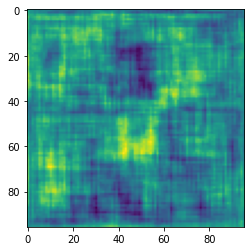

In [ ]:
generator = build_generator(SEED_SIZE, IMAGE_CHANNELS)

noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

In [ ]:
image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS)

discriminator = build_discriminator(image_shape)
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.49995095]], shape=(1, 1), dtype=float32)


In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
  seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(seed, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    

    gradients_of_generator = gen_tape.gradient(\
        gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(\
        disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(
        gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(
        gradients_of_discriminator, 
        discriminator.trainable_variables))
  # generate_and_save_images(generator, epochs, seed)
  return gen_loss,disc_loss

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


In [ ]:
def train(dataset, epochs):
  fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS, 
                                       SEED_SIZE))
  start = time.time()

  for epoch in range(epochs):
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []

    for image_batch in dataset:
      t = train_step(image_batch)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])

    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)

    epoch_elapsed = time.time()-epoch_start
    print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss}, time={hms_string(epoch_elapsed)}')
    
    display.clear_output(wait=True)
    print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss}, time={hms_string(epoch_elapsed)}')
    save_images(epoch,fixed_seed)

  display.clear_output(wait=True)
  print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss}, time={hms_string(epoch_elapsed)}')
  save_images(epoch,fixed_seed)

  elapsed = time.time()-start
  print (f'Training time: {hms_string(elapsed)}')

Epoch 79, gen loss=10.863269805908203,disc loss=0.06242196634411812, time=0:02:44.74


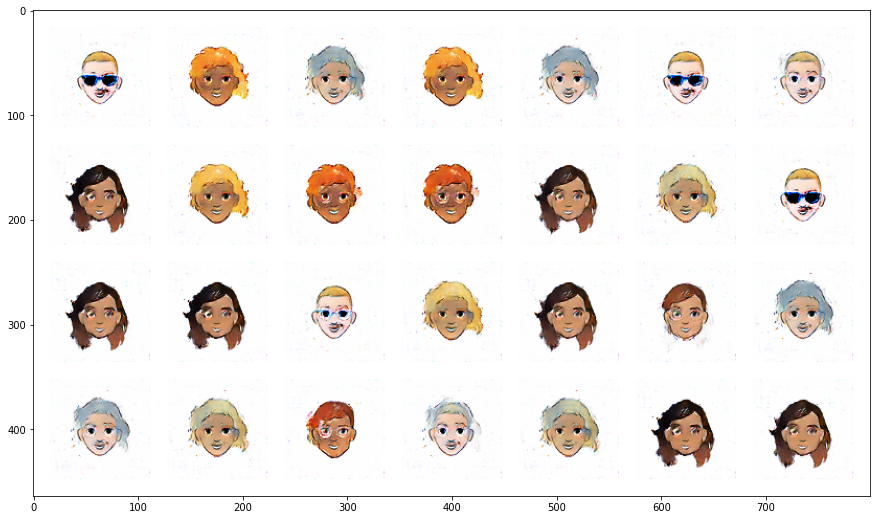

In [ ]:
train(train_dataset, EPOCHS)

In [ ]:
weights_name = f"face_generator_{EPOCHS}.h5"
print(weights_name)
generator.save(os.path.join(DATA_PATH, weights_name))